### Install Dependencies

In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
# --- Complete Environment Verification ---

print("="*50)
print("Verifying all project libraries...")
print("="*50)

success_count = 0
error_count = 0

def check_library(import_name, package_name, version_attribute='__version__'):
    """Tries to import a library and print its version."""
    global success_count, error_count
    try:
        module = __import__(import_name)
        version = getattr(module, version_attribute)
        print(f"✅ {package_name:<20} | Version: {version}")
        success_count += 1
    except (ImportError, AttributeError):
        print(f"❌ {package_name:<20} | NOT FOUND or version attribute incorrect.")
        error_count += 1

# --- List of Libraries to Check ---
# Format: (import_name, display_name)
libraries_to_check = [
    ('tensorflow', 'TensorFlow'),
    ('cv2', 'OpenCV'),
    ('matplotlib', 'Matplotlib'),
    ('albumentations', 'Albumentations'),
    ('labelme', 'LabelMe'),
    ('numpy', 'NumPy'),         # A core dependency, good to check
    ('PIL', 'Pillow (PIL)')     # Often used for image processing
]

# --- Run the Checks ---
for lib_import, lib_name in libraries_to_check:
    check_library(lib_import, lib_name)

# --- Final Summary ---
print("="*50)
if error_count == 0:
    print("🎉 All libraries are installed and ready to go!")
else:
    print(f"⚠️ Found {error_count} missing or problematic libraries. Please install or reinstall them.")
print("="*50)

# You can also check the Python interpreter path for final confirmation
import sys
print(f"\nJupyter is running on this Python interpreter:\n{sys.executable}")

Verifying all project libraries...
✅ TensorFlow           | Version: 2.10.0
✅ OpenCV               | Version: 4.6.0
✅ Matplotlib           | Version: 3.9.1
✅ Albumentations       | Version: 1.3.1
✅ LabelMe              | Version: 5.2.1
✅ NumPy                | Version: 1.26.4
✅ Pillow (PIL)         | Version: 9.4.0
🎉 All libraries are installed and ready to go!

Jupyter is running on this Python interpreter:
C:\Users\sride\miniconda3\envs\facedetect-final\python.exe


### Collect Images using CV

In [3]:
import os
import time
import uuid
import cv2

In [4]:
img_path=os.path.join('data','images')
num_of_imgs=30

In [7]:
cap=cv2.VideoCapture(0)
for imgnum in range(num_of_imgs):
    print('Collecting image {}'.format(imgnum))
    ret,frame=cap.read()
    img_name=os.path.join(img_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(img_name,frame)
    cv2.imshow('frame',frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### Label Images

In [8]:
!labelme

#### Import Dependencies

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

#### Load Data into TF Pipeline

In [4]:
images=tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [ ]:
images.as_numpy_iterator().next()

In [5]:
def load_img(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images=images.map(load_img)

In [15]:
images.as_numpy_iterator().next()

array([[[252, 246, 234],
        [252, 246, 234],
        [252, 246, 234],
        ...,
        [193, 194, 180],
        [193, 194, 180],
        [193, 194, 180]],

       [[251, 245, 233],
        [251, 245, 233],
        [251, 245, 233],
        ...,
        [193, 194, 180],
        [193, 194, 180],
        [193, 194, 180]],

       [[250, 244, 232],
        [250, 244, 232],
        [250, 244, 232],
        ...,
        [196, 194, 181],
        [196, 194, 181],
        [196, 194, 181]],

       ...,

       [[137, 131, 119],
        [137, 131, 119],
        [137, 131, 119],
        ...,
        [ 41,  28,   9],
        [ 42,  29,  10],
        [ 42,  29,  10]],

       [[137, 131, 119],
        [136, 130, 118],
        [136, 130, 118],
        ...,
        [ 44,  29,  10],
        [ 42,  29,  10],
        [ 42,  29,  10]],

       [[138, 132, 120],
        [138, 132, 120],
        [137, 131, 119],
        ...,
        [ 43,  28,   9],
        [ 41,  28,   9],
        [ 42,  29,  10]]

#### Visualize the data

In [16]:
image_generator=images.batch(4).as_numpy_iterator()    #batch= no. of img to be shown at a time

In [19]:
plot_img=image_generator.next()

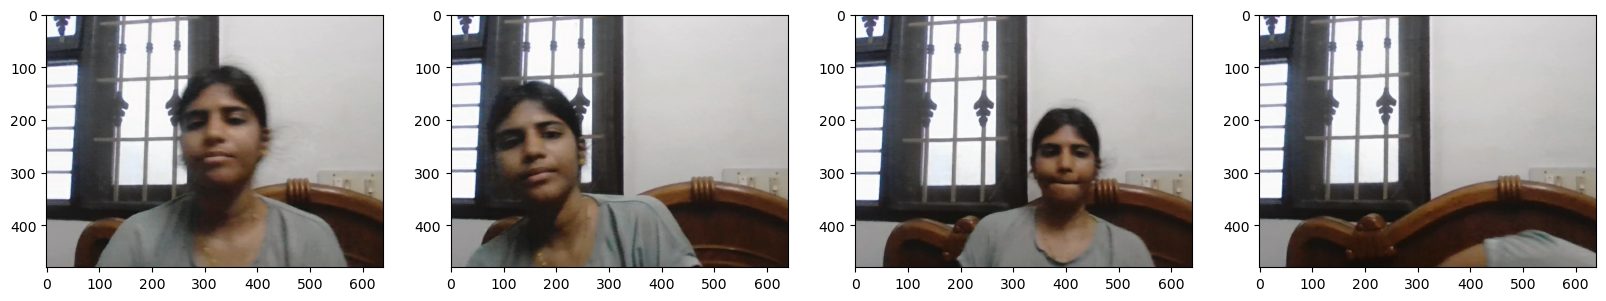

In [20]:
fig,ax= plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_img):
    ax[idx].imshow(image)
plt.show()

### Split the data

In [38]:
'''
Split the data manually
90*.7= 63 --- train
14 -- test
13 -- val
'''

'\nSplit the data manually\n90*.7= 63 --- train\n14 -- test\n13 -- val\n'

#### Move the matching label to its folder


In [22]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):

        filename=file.split('.')[0]+'.json'
        existing_filepath=os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath= os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

## Apply image augmentation on images and labels using Albumentation

#### Setup Albumentation pipeline

In [26]:
img=cv2.imread(os.path.join('data','train','images','0c68b03f-9856-11f0-81d0-a77e419dc414.jpg'))

In [27]:
img.shape

(480, 640, 3)

In [28]:
import albumentations as alb

In [29]:
augmentor= alb.Compose([alb.RandomCrop(width=450,height=450),
                       alb.HorizontalFlip(p=0.5),
                       alb.RandomBrightnessContrast(p=0.2),
                       alb.RGBShift(p=0.2),
                       alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                 label_fields=['class_labels']))

##### Load a test image and annotate with OpenCV and JSON

In [30]:
img=cv2.imread(os.path.join('data','train','images','0a8ab48c-9856-11f0-9cc3-a77e419dc414.jpg'))

In [31]:
img.shape

(480, 640, 3)

In [32]:
with open(os.path.join('data','train','labels','0a8ab48c-9856-11f0-9cc3-a77e419dc414.json'), 'r') as f:
    label=json.load(f)

In [33]:
label['shapes'][0]['points']

[[1.2820512820512846, 193.33333333333331],
 [73.07692307692308, 437.43589743589746]]

In [34]:
coords=[0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [35]:
coords   # pascal_voc formal

[1.2820512820512846, 193.33333333333331, 73.07692307692308, 437.43589743589746]

In [36]:
 coords=list(np.divide(coords,[640,480,640,480]))

In [37]:
coords   # albumentations format

[0.0020032051282051324,
 0.40277777777777773,
 0.11418269230769232,
 0.9113247863247864]

#### Apply Augmentations and view result

In [38]:
augmented= augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [39]:
augmented['bboxes']

[(0.0006267806267806325,
  0.41851851851851846,
  0.1601709401709402,
  0.9609686609686611)]

In [40]:
augmented['bboxes'][0][:2]

(0.0006267806267806325, 0.41851851851851846)

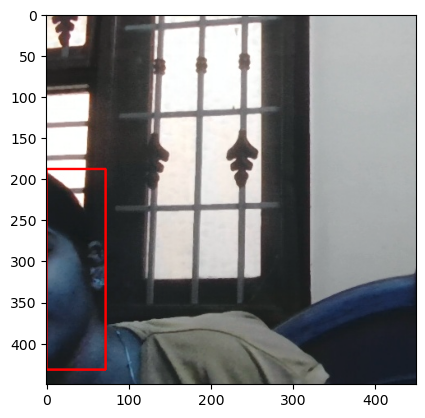

In [41]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
             (255,0,0),2)
plt.imshow(augmented['image'])

## Build and Run Augmentation pipeline

In [62]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img=cv2.imread(os.path.join('data',partition,'images',image))

        coords=[0,0,0.00001,0.00001]
        label_path= os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label=json.load(f)

            coords[0]=label['shapes'][0]['points'][0][0]
            coords[1]=label['shapes'][0]['points'][0][1]
            coords[2]=label['shapes'][0]['points'][1][0]
            coords[3]=label['shapes'][0]['points'][1][1]
            coords=list(np.divide(coords,[640,480,640,480]))

        try:
            for x in range(60):
                augmented= augmentor(image=img,bboxes=[coords],class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f'{image.split(".")[0]}+{x}.jpg'), augmented['image'])

                annotation= {}
                annotation['image']=image

                if os.path.exists(label_path):
                    if len(augmented['bboxes'])==0:
                        annotation['bbox']= [0,0,0,0]
                        annotation['class']=0
                    else:
                        annotation['bbox']=augmented['bboxes'][0]
                        annotation['class']=1
                else:
                    annotation['bbox']=[0,0,0,0]
                    annotation['class']=0

                with open(os.path.join('aug_data',partition,'labels',f'{image.split(".")[0]}.{x}.json'),'w') as f:
                    json.dump(annotation,f)

        except Exception as e:
            print(e)

### Load Augmented Images to Tensorflow dataset

In [6]:
train_images= tf.data.Dataset.list_files("aug_data\\train\\images\\*.jpg", shuffle=False)
train_images= train_images.map(load_img)
train_images= train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images= train_images.map(lambda x: x/255)

In [7]:
test_images= tf.data.Dataset.list_files("aug_data\\test\\images\\*.jpg", shuffle=False)
test_images= test_images.map(load_img)
test_images= test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images= test_images.map(lambda x: x/255)

In [8]:
val_images= tf.data.Dataset.list_files("aug_data\\val\\images\\*.jpg", shuffle=False)
val_images= val_images.map(load_img)
val_images= val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images= val_images.map(lambda x: x/255)

In [9]:
train_images.as_numpy_iterator().next()

array([[[0.3981005 , 0.4283701 , 0.37009802],
        [0.39846814, 0.4213848 , 0.36648285],
        [0.4041054 , 0.41979167, 0.3648897 ],
        ...,
        [0.18333334, 0.12745099, 0.05294118],
        [0.17616421, 0.12775736, 0.05490196],
        [0.16170344, 0.12591912, 0.05104167]],

       [[0.42843136, 0.4509804 , 0.39607844],
        [0.41917893, 0.44270834, 0.3938113 ],
        [0.40490195, 0.42843136, 0.3735294 ],
        ...,
        [0.16409314, 0.12064951, 0.05098039],
        [0.15588236, 0.12101716, 0.05435049],
        [0.15802696, 0.12371323, 0.05655637]],

       [[0.43382353, 0.44460785, 0.39215687],
        [0.42340687, 0.4392157 , 0.38431373],
        [0.4231005 , 0.43878677, 0.38388482],
        ...,
        [0.14160539, 0.10631128, 0.03964461],
        [0.12990196, 0.10245098, 0.03970588],
        [0.12432598, 0.10079657, 0.04234068]],

       ...,

       [[0.9882353 , 0.9647059 , 0.91764706],
        [0.9882353 , 0.9647059 , 0.91764706],
        [0.9882353 , 0

### Prepare Labels

##### Build Label loading function

In [10]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding= 'utf-8') as f:
        label=json.load(f)

    return [label['class']], label['bbox']

##### Load Labels to TF Dataset

In [11]:
train_labels= tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)

In [12]:
train_labels.as_numpy_iterator().next()

b'aug_data\\train\\labels\\00996bb8-9856-11f0-a785-a77e419dc414.0.json'

In [13]:
train_labels= tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels= train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
test_labels= tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels= test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
val_labels= tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels= val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [16]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1981, 0.1609, 0.679 , 0.808 ], dtype=float16))

### Combine Images and Labels

##### Check partition length

In [17]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

##### Create final Datasets

In [18]:
train= tf.data.Dataset.zip((train_images,train_labels))
train= train.shuffle(5000)
train= train.batch(8)
train= train.prefetch(4)

In [19]:
test= tf.data.Dataset.zip((test_images, test_labels))
test= test.shuffle(1300)
test= test.batch(8)
test= test.prefetch(4)

In [20]:
val= tf.data.Dataset.zip((val_images,val_labels))
val= val.shuffle(1000)
val= val.batch(8)
val= val.prefetch(4)

In [21]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.3032 , 0.3076 , 0.8057 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.28   , 0.2666 , 0.81   , 0.874  ],
        [0.412  , 0.1909 , 0.801  , 0.658  ],
        [0.1947 , 0.3389 , 0.657  , 0.7363 ],
        [0.     , 0.05716, 0.08966, 0.6313 ],
        [0.2876 , 0.3313 , 0.682  , 0.787  ],
        [0.543  , 0.2435 , 1.     , 0.845  ]], dtype=float16))

#### View image and label

In [22]:
data_samples= train.as_numpy_iterator()

In [23]:
res= data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


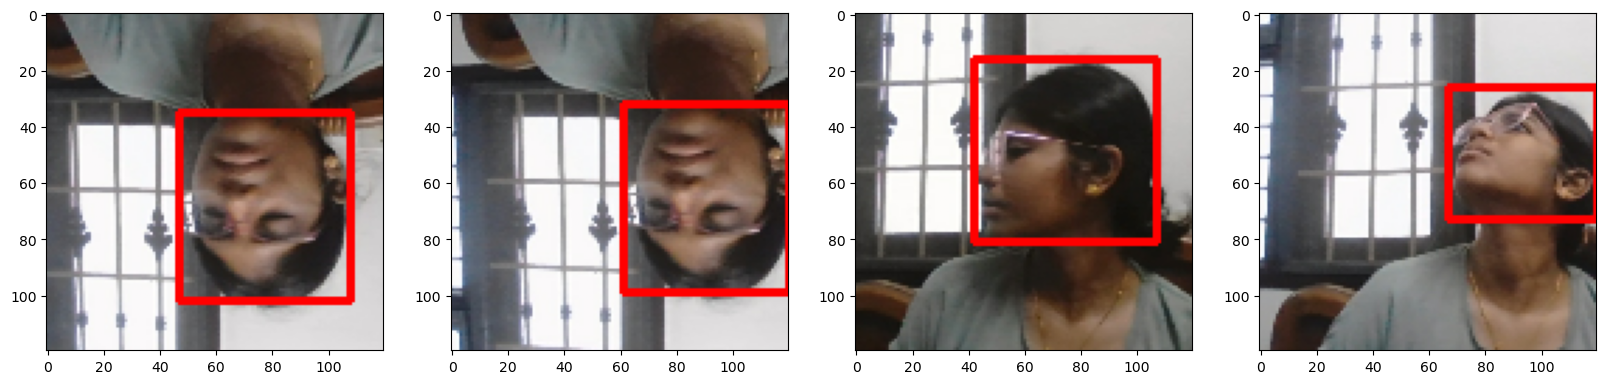

In [24]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image= res[0][idx]
    sample_coords= res[1][1][idx]

    cv2.rectangle(sample_image,
                 tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                 tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                 (255,0,0),2)

    ax[idx].imshow(sample_image)

# Build Deep Learning Model

#### Import layers

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [26]:
vgg= VGG16(include_top=False)

In [27]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### Build instance of Network

In [28]:
def build_model():
    input_layer= Input(shape=(120,120,3))

    vgg= VGG16(include_top=False)(input_layer)
    
    # Classification
    f1= GlobalMaxPooling2D()(vgg)
    class1= Dense(2048,activation='relu')(f1)
    class2= Dense(1, activation='sigmoid')(class1)
    
    # Regression (Bounding Box)
    f2= GlobalMaxPooling2D()(vgg)
    regress1= Dense(2048, activation='relu')(f2)
    regress2= Dense(4, activation='sigmoid')(regress1)

    facetracker= Model(inputs= input_layer, outputs= [class2,regress2])
    return facetracker

#### Test Neural Network

In [29]:
facetracker= build_model()

In [30]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [31]:
X, y = train.as_numpy_iterator().next()

In [32]:
X.shape

(8, 120, 120, 3)

In [33]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 3s 3s/step


In [34]:
classes, coords

(array([[0.27789235],
        [0.31838965],
        [0.3366646 ],
        [0.31403095],
        [0.28563917],
        [0.23526208],
        [0.28522965],
        [0.35889012]], dtype=float32),
 array([[0.5436908 , 0.717783  , 0.41441494, 0.5889257 ],
        [0.5686134 , 0.704042  , 0.43953207, 0.618394  ],
        [0.6322832 , 0.6666225 , 0.48003915, 0.56064296],
        [0.5790428 , 0.7467492 , 0.41327047, 0.5889396 ],
        [0.5507423 , 0.721754  , 0.36058652, 0.6268865 ],
        [0.49742094, 0.6609826 , 0.4721096 , 0.57708794],
        [0.6031612 , 0.70083463, 0.47515544, 0.6122501 ],
        [0.5250492 , 0.7312689 , 0.35349873, 0.57720864]], dtype=float32))

## Define Losses and Optimizers

#### Define Optimizer and LR(learning rate)

In [35]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/ batches_per_epoch

In [36]:
opt= tf.keras.optimizers.Adam(learning_rate=0.0001, decay= lr_decay)

#### Create Localization loss and Classification Loss

In [37]:
def localization_loss(y_true, yhat):
    delta_coord= tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true= y_true[:,3] - y_true[:,1]
    w_true= y_true[:,2] - y_true[:,0]

    h_pred= yhat[:,3] - yhat[:,1]
    w_pred= yhat[:,2] - yhat[:,0]

    delta_size= tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [38]:
classloss= tf.keras.losses.BinaryCrossentropy()
regressloss= localization_loss

#### Test Loss metrics

In [39]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.215375>

In [40]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1216272>

In [41]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.215375>

## Train Neural Network

In [42]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model= eyetracker

    def compile(self,opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs= classloss
        self.lloss= localizationloss
        self.opt= opt

    def train_step(self, batch, **kwargs):
        X, y= batch

        with tf.GradientTape() as tape:
            classes, coords= self.model(X, training= True)

            batch_classloss= self.closs(y[0], classes)
            batch_localizationloss= self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss= batch_localizationloss+0.5*batch_classloss

            grad= tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y= batch

        classes, coords= self.model(X, training=False)

        batch_classloss= self.closs(y[0], classes)
        batch_localizationloss= self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss= batch_localizationloss+0.5*batch_classloss

        return {"total_loss": total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [43]:
model= FaceTracker(facetracker)

In [44]:
model.compile(opt, classloss, regressloss)

##### Train

In [45]:
logdir= 'logs'

In [46]:
tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [47]:
 hist= model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
473/473 [==============================] - 594s 1s/step - total_loss: 0.3517 - class_loss: 0.0922 - regress_loss: 0.3056 - val_total_loss: 0.0361 - val_class_loss: 5.5795e-05 - val_regress_loss: 0.0360
Epoch 2/20
473/473 [==============================] - 606s 1s/step - total_loss: 0.0677 - class_loss: 0.0174 - regress_loss: 0.0590 - val_total_loss: 0.0340 - val_class_loss: 1.5703e-04 - val_regress_loss: 0.0339
Epoch 3/20
473/473 [==============================] - 625s 1s/step - total_loss: 0.0518 - class_loss: 0.0148 - regress_loss: 0.0444 - val_total_loss: 0.0185 - val_class_loss: 1.8403e-05 - val_regress_loss: 0.0185
Epoch 4/20
473/473 [==============================] - 3929s 8s/step - total_loss: 0.0486 - class_loss: 0.0141 - regress_loss: 0.0415 - val_total_loss: 0.0160 - val_class_loss: 5.8745e-05 - val_regress_loss: 0.0160
Epoch 5/20
473/473 [==============================] - 825s 2s/step - total_loss: 0.0518 - class_loss: 0.0145 - regress_loss: 0.0446 - val_total_los

#### Plot Performance

In [48]:
hist.history

{'total_loss': [0.020180130377411842,
  0.008120962418615818,
  0.019525889307260513,
  0.00650169188156724,
  0.00649065850302577,
  0.0026391532737761736,
  0.0014476224314421415,
  0.0017803229857236147,
  0.002110054949298501,
  0.0008171022054739296,
  0.002187165431678295,
  0.0017083350103348494,
  0.0003100703179370612,
  0.000730742933228612,
  0.00032905471744015813,
  0.00044297758722677827,
  0.0015692429151386023,
  0.0010068264091387391,
  0.0003563972422853112,
  0.00026057253126055],
 'class_loss': [0.02405145764350891,
  0.00030617500306107104,
  0.011942151002585888,
  5.3990115702617913e-05,
  0.00011953448120038956,
  2.7940488507738337e-05,
  3.855061368085444e-05,
  7.5549419307208154e-06,
  4.0562492358731106e-05,
  9.611326277081389e-06,
  4.1574380702513736e-06,
  3.516687456794898e-06,
  5.1441653340589255e-05,
  2.0861631355728605e-07,
  9.894465620163828e-06,
  0.00012399184925016016,
  4.887599061476067e-06,
  2.682216745597543e-06,
  7.316525625356007e-06,

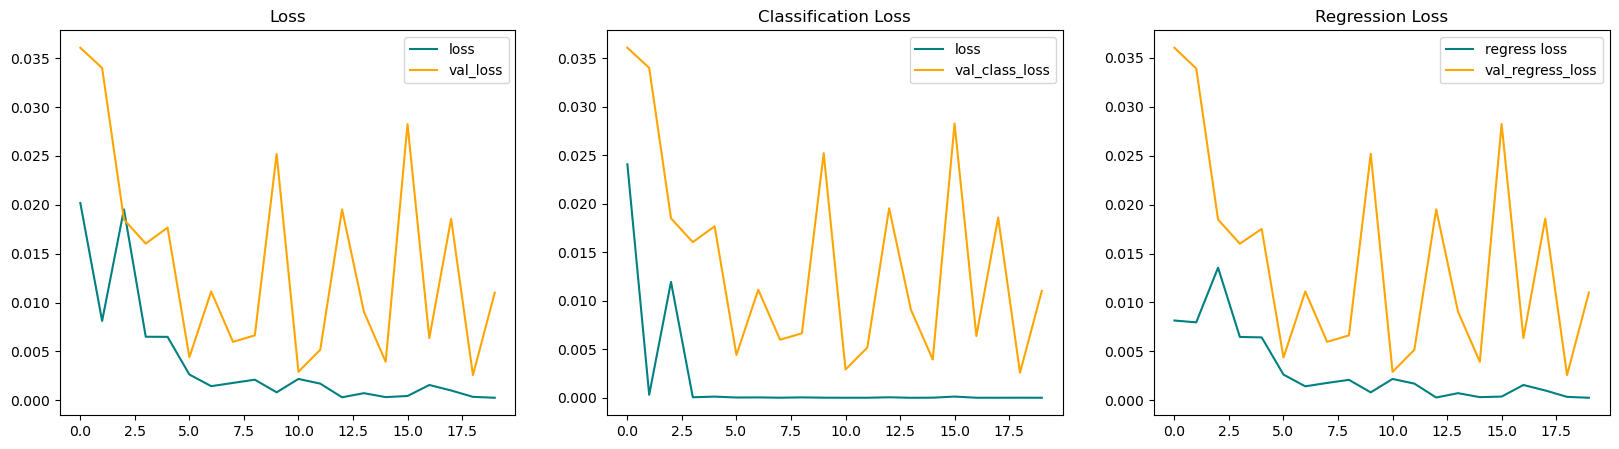

In [50]:
fig,ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'],color='teal',label='loss')
ax[0].plot(hist.history['val_total_loss'],color='orange',label='val_loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'],color='teal',label='loss')
ax[1].plot(hist.history['val_total_loss'],color='orange',label='val_class_loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'],color='teal',label='regress loss')
ax[2].plot(hist.history['val_regress_loss'],color='orange',label='val_regress_loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### Make Predictions

##### Make Predictions on Test Set

In [52]:
test_data= test.as_numpy_iterator()

In [110]:
test_sample= test_data.next()

In [111]:
yhat= facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 495ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


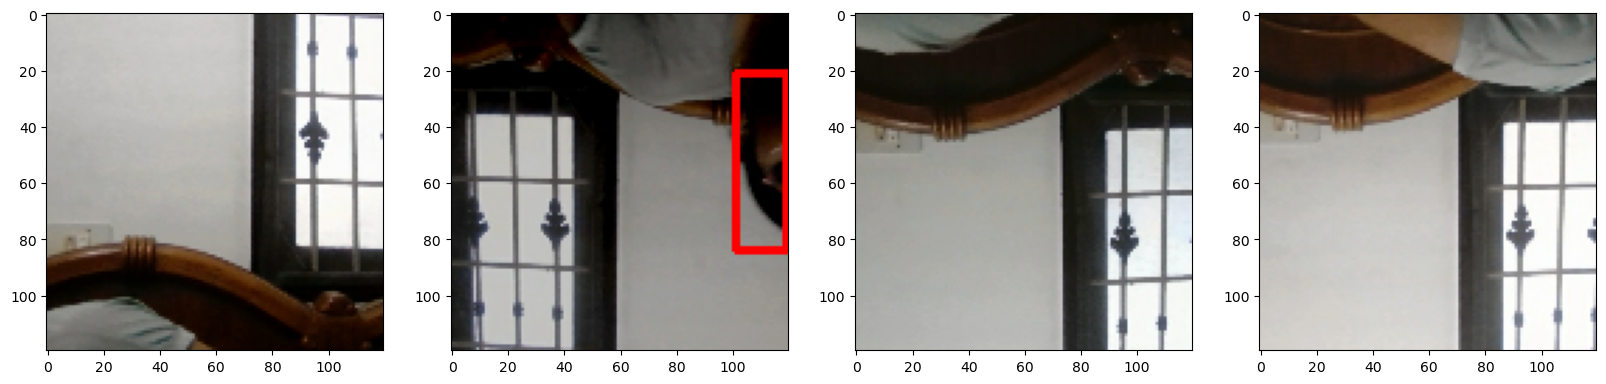

In [112]:
fig, ax= plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image= test_sample[0][idx]
    sample_coords= yhat[1][idx]

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                     tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                     tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                     (255,0,0),2)

    ax[idx].imshow(sample_image)

#### Save the Model

In [114]:
from tensorflow.keras.models import load_model

In [116]:
facetracker.save('facetracker.h5')

### Real Time Detection

In [117]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 93ms/step
